# Setup

In [ ]:
!git clone -b develop https://github.com/StarkitRobots/cvr_course

In [ ]:
cd cvr_course/notebooks

# Stereo pair calibration

- Intrinsic_mtx_1 - матрица 1 камеры
- dist_1 - коэффициенты дисторсии 1 камеры
- Intrinsic_mtx_2 - матрица 2 камеры
- dist_2 - коэффициенты дисторсии 2 камеры

- R - матрица поворота между камерами
- T - матрица трансляции между камерами

https://github.com/bvnayak/stereo_calibration.git

In [11]:
import numpy as np
import cv2
import glob
import argparse

class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (cv2.TERM_CRITERIA_EPS +
                             cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9*7, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:9, 0:7].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        images_right = glob.glob(cal_path + 'right*.png')
        images_left = glob.glob(cal_path + 'left*.png')
        images_left.sort()
        images_right.sort()

        print ("images_left", images_left, images_right)

        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(gray_l, (9, 7), None)
            ret_r, corners_r = cv2.findChessboardCorners(gray_r, (9, 7), None)

            # If found, add object points, image points (after refining them)
            self.objpoints.append(self.objp)

            if ret_l is True:
                rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                ret_l = cv2.drawChessboardCorners(img_l, (9, 7),
                                                  corners_l, ret_l)
                #cv2.imshow(images_left[i], img_l)
                cv2.waitKey(500)

            if ret_r is True:
                rt = cv2.cornerSubPix(gray_r, corners_r, (11, 11),
                                      (-1, -1), self.criteria)
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                ret_r = cv2.drawChessboardCorners(img_r, (9, 7),
                                                  corners_r, ret_r)
                #cv2.imshow(images_right[i], img_r)
                cv2.waitKey(100)
            img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None)
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None)

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5

        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                                cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints, self.imgpoints_l,
            self.imgpoints_r, self.M1, self.d1, self.M2,
            self.d2, dims,
            criteria=stereocalib_criteria, flags=flags)

        print('Intrinsic_mtx_1', M1)
        print('dist_1', d1)
        print('Intrinsic_mtx_2', M2)
        print('dist_2', d2)
        print('R', R)
        print('T', T)
        print('E', E)
        print('F', F)

        # for i in range(len(self.r1)):
        #     print("--- pose[", i+1, "] ---")
        #     self.ext1, _ = cv2.Rodrigues(self.r1[i])
        #     self.ext2, _ = cv2.Rodrigues(self.r2[i])
        #     print('Ext1', self.ext1)
        #     print('Ext2', self.ext2)

        print('')

        camera_model = dict([('M1', M1), ('M2', M2), ('dist1', d1),
                            ('dist2', d2), ('rvecs1', self.r1),
                            ('rvecs2', self.r2), ('R', R), ('T', T),
                            ('E', E), ('F', F)])

        cv2.destroyAllWindows()
        return camera_model

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('filepath', help='String Filepath')
#     args = parser.parse_args()
#     cal_data = StereoCalibration(args.filepath)


In [12]:
#from stereo_calibration.camera_calibrate import StereoCalibration
cal = StereoCalibration('../data/imgs/calibrationdat/')
cal.camera_model

images_left ['../data/imgs/calibrationdat/left-0000.png', '../data/imgs/calibrationdat/left-0001.png', '../data/imgs/calibrationdat/left-0002.png', '../data/imgs/calibrationdat/left-0003.png', '../data/imgs/calibrationdat/left-0004.png', '../data/imgs/calibrationdat/left-0005.png', '../data/imgs/calibrationdat/left-0006.png', '../data/imgs/calibrationdat/left-0007.png'] ['../data/imgs/calibrationdat/right-0000.png', '../data/imgs/calibrationdat/right-0001.png', '../data/imgs/calibrationdat/right-0002.png', '../data/imgs/calibrationdat/right-0003.png', '../data/imgs/calibrationdat/right-0004.png', '../data/imgs/calibrationdat/right-0005.png', '../data/imgs/calibrationdat/right-0006.png', '../data/imgs/calibrationdat/right-0007.png']
Intrinsic_mtx_1 [[528.92971095   0.         331.42886362]
 [  0.         527.52644973 226.75469672]
 [  0.           0.           1.        ]]
dist_1 [[-2.11291512e-02  3.86518866e-01 -9.74649741e-05 -8.04617066e-03
  -1.07309518e+00]]
Intrinsic_mtx_2 [[540.

{'M1': array([[528.92971095,   0.        , 331.42886362],
        [  0.        , 527.52644973, 226.75469672],
        [  0.        ,   0.        ,   1.        ]]),
 'M2': array([[540.64063546,   0.        , 305.72909461],
        [  0.        , 538.78100342, 224.08417356],
        [  0.        ,   0.        ,   1.        ]]),
 'dist1': array([[-2.11291512e-02,  3.86518866e-01, -9.74649741e-05,
         -8.04617066e-03, -1.07309518e+00]]),
 'dist2': array([[ 0.01986222, -0.01022669,  0.00145097, -0.0073049 , -0.03501859]]),
 'rvecs1': [array([[-0.1636584 ],
         [ 0.70498388],
         [ 2.76465316]]),
  array([[-0.12892797],
         [ 0.69493352],
         [ 2.94123178]]),
  array([[-0.32698814],
         [-0.00034848],
         [ 0.01013225]]),
  array([[-0.10304573],
         [-0.45069216],
         [-3.09902395]]),
  array([[-0.13741482],
         [-0.41571386],
         [-3.11173667]]),
  array([[-0.23186588],
         [ 0.09767764],
         [ 0.07059253]]),
  array([[-0.4836

# Disparity map obtainment

https://github.com/OmarPadierna/3DReconstruction

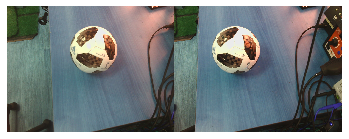

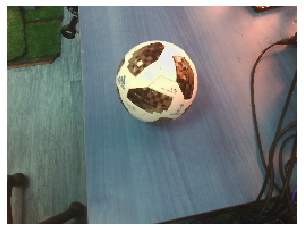

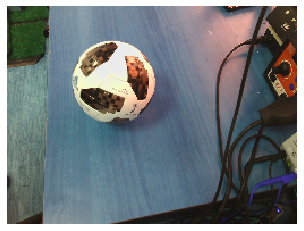


Computing the disparity  map...


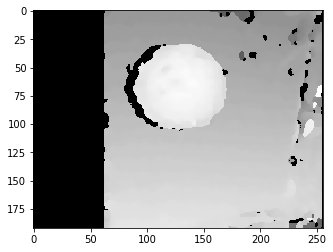

In [13]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 

#=====================================
# Function declarations
#=====================================

#Function to create point cloud file
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image


img = cv2.imread ("../data/imgs/stereopairs/sp2.jpg")

plt.imshow (img)
plt.axis ('off')
plt.show ()

img_downsampled = cv2.resize (img, (512, 192))

img_1_downsampled = img_downsampled [:, :256, :]
img_2_downsampled = img_downsampled [:, 256:, :]

plt.imshow (img_1_downsampled)
plt.axis ('off')
plt.show ()

plt.imshow (img_2_downsampled)
plt.axis ('off')
plt.show ()

#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5,
	uniquenessRatio = 5,
	speckleWindowSize = 5,
	speckleRange = 5,
	disp12MaxDiff = 2,
	P1 = 8*3*win_size**2,#8*3*win_size**2,
	P2 =32*3*win_size**2) #32*3*win_size**2)

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

# Point cloud generation

In [14]:
#Generate point cloud. 
print ("\nGenerating the 3D map...")

#Get new downsampled width and height 
h,w = img_2_downsampled.shape[:2]

#Load focal length. 
#focal_length = np.load('./camera_params/FocalLength.npy')
focal_length = 517

#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
# Q = np.float32([[1,0,0,-w/2.0],
# 				[0,-1,0,h/2.0],
# 				[0,0,0,-focal_length],
# 				[0,0,1,0]])

#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
# Q2 = np.float32([[1,0,0,0],
# 				[0,-1,0,0],
# 				[0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
# 				[0,0,0,1]])

M1 = cal.camera_model ["M1"]
M2 = cal.camera_model ["M1"]
D1 = cal.camera_model ["dist1"]
D2 = cal.camera_model ["dist2"]
R = cal.camera_model ["R"]
T = cal.camera_model ["T"]

R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(M1, D1,
    M2, D2, (h, w), R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0.9)

print ("Q", Q)

#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

#Get color points
colors = cv2.cvtColor(img_1_downsampled, cv2.COLOR_BGR2RGB)

#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

#Define name for output file
#output_file = 'reconstructed.ply'

#Generate point cloud 
#print ("\n Creating the output file... \n")
#create_output(output_points, output_colors, output_file)

print (output_points)
print (len (output_points))


Generating the 3D map...
Q [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -4.05860605e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.34690842e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.91025420e+02]
 [ 0.00000000e+00  0.00000000e+00  3.48529556e-01 -0.00000000e+00]]
[[-2.3923547  -1.6423763   2.7364123 ]
 [-2.501269   -1.7221849   2.8693836 ]
 [-2.493931   -1.7221849   2.8693836 ]
 ...
 [-1.6040636  -0.45255464  4.0502853 ]
 [-1.554424   -0.44140014  3.9504542 ]
 [-1.5443212  -0.44140014  3.9504542 ]]
35715


# Projecting 3D objects onto plane

In [15]:
import cv2
import numpy as np
import time
import math

from IPython.display import display, clear_output
from matplotlib import pyplot as plt

WIND_X = 1100
WIND_Y = 700

class Object:
    def __init__ (self, x_, y_, z_):
        self.x = x_
        self.y = y_
        self.z = z_
    
    def get_coords (self):
        return [self.x, self.y, self.z]
    
    def change_coord (self, coord, val, increment = False):
        if (coord == "x"):
            if (increment == True):
                self.x += val            
            else:
                self.x = val

        if (coord == "y"):
            if (increment == True):
                self.y += val            
            else:
                self.y = val

        if (coord == "z"):
            if (increment == True):
                self.z += val            
            else:
                self.z = val

    def draw (self, canvas):
        pass

class Light_emitter (Object):
    def __init__ (self, x_, y_, z_, color_ = (255, 255, 255)):
        Object.__init__ (self, x_, y_, z_)
        
        self.color = color_
    
    def get_color (self):
        return self.color
    
    def draw (self, canvas):
        pass
        #cv2.circle (canvas, (int (self.x / self.z), int (self.y / self.z)),
        #    10, (250, 250, 250), -1)

class Surface (Object):
    def __init__ (self, x_, y_, z_):
        Object.__init__ (x_, y_, z_)
    
    def draw (self, canvas):
        self.render (canvas)
    
    def render (self, canvas):
        pass
    
    def iterate_elements (self):
        pass
    
    def calc_element_lightening (self):
        pass
    
    def _dotproduct (self, v1, v2):
        return sum ((a * b) for a, b in zip (v1, v2))

    def _length(self, v):
        return math.sqrt (self._dotproduct (v, v))

    def _cos (self, v1, v2):
        return self._dotproduct (v1, v2) / (self._length (v1) * self._length (v2))
    
    def _subtr (self, v1, v2):
        return [a - b for a, b in zip (v1, v2)]

class Sphere(Surface):
    def __init__ (self, x_, y_, z_, r_, color_ = (100, 100, 255)):
        Object.__init__ (self, x_, y_, z_)
        
        self.r     = r_
        self.color = color_
    
    def iterate_elements (self):
        result = []
        
        for i in range (int (- self.r / self.z), int (self.r / self.z)):
            for j in range (int (- self.r / self.z), int (self.r / self.z)):
                dist_2d = self._length ((i, j))
                
                if (dist_2d < self.r / self.z):
                    n = []
                    
                    n.append (i * self.z)
                    n.append (j * self.z)
                    n.append (math.sqrt ((self.r)**2 - (dist_2d * self.z)**2))
                    
                    result.append ((self.x / self.z + i, self.y / self.z + j, n))
        
        return result
    
    def draw (self, canvas, emitter):
        self.render (canvas, emitter)
    
    def render (self, canvas, emitter):
        for i, j, n in self.iterate_elements ():
            pix_color = self.calc_lightening (n, emitter)
            
            canvas [int (j), int (i), :] = pix_color
    
    def calc_lightening (self, n, emitter):
        p_vec = [self.x + n [0], self.y + n [1], self.z + n [2]]
        vec = self._subtr (emitter.get_coords (), p_vec)
        cos = max (self._cos (n, vec), 0)
        
        result = [int (channel * cos) for channel in self.color]
        
        return result

emitter = Light_emitter (350, 200, 400)

spheres = [Sphere (300, 350, 1, 250),
           #Sphere (500, 450, 1, 150, color_ = (250, 24, 100)),
           #Sphere (650, 250, 1, 100, color_ = (25, 240, 10)),
           #Sphere (750, 150, 1, 100, color_ = (125, 200, 10)),
           #Sphere (850, 345, 1, 100, color_ = (225, 240, 10)),
           Sphere (950, 125, 1, 100, color_ = (250, 20, 255))]

to_refresh = True

canvas = np.ones ((WIND_Y, WIND_X, 3), np.uint8) * 55

while (True):
    k = cv2.waitKey (50) & 0xFF
    
    if (k != 255):
        to_refresh = True
    
    if (k == ord ('q')):
        break
    
    step = 20
    
    if (k == ord ('d')):
        emitter.change_coord ("x", step, increment = True)

    if (k == ord ('a')):
        emitter.change_coord ("x", -step, increment = True)

    if (k == ord ('s')):
        emitter.change_coord ("y", step, increment = True)

    if (k == ord ('w')):
        emitter.change_coord ("y", -step, increment = True)

    if (k == ord ('r')):
        emitter.change_coord ("z", 0.1, increment = True)

    if (k == ord ('f')):
        emitter.change_coord ("z", -0.1, increment = True)
    
    if (to_refresh == True):
        to_refresh = False
        canvas = np.ones ((WIND_Y, WIND_X, 3), np.uint8) * 55
        
        print ("rendering...")
        
        before_time = time.time ()
        
        for sphere in spheres:
            sphere.draw (canvas, emitter)
        
        print ("rendered in ", str (time.time () - before_time) [:6], "seconds")
        
        emitter.draw (canvas)
    
    light_info_str  = "light: " + str (emitter.get_coords ())
    sphere_info_str = "sphere: " + str (sphere.get_coords ())
    
    canvas = cv2.putText (canvas, light_info_str, (20, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 25, 130), 1, cv2.LINE_AA)

    canvas = cv2.putText (canvas, sphere_info_str, (20, 60),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 25, 130), 1, cv2.LINE_AA)
    
    #cv2.imshow ("render", canvas)
    plt.figure(figsize=(20,10))

    plt.imshow (canvas)
    plt.show ()
    plt.pause (0.1)
    
    clear_output(wait = True)

cv2.waitKey (0)
cv2.destroyAllWindows ()

KeyboardInterrupt: 

In [16]:
import cv2
import numpy as np
import time
import math

from IPython.display import display, clear_output
from matplotlib import pyplot as plt
#plt.rcParams["figure.figsize"] = (20, 20)
#%matplotlib inline

WIND_X = 1000
WIND_Y = 800

class Object:
    def __init__ (self, x_, y_, z_):
        self.x = x_
        self.y = y_
        self.z = z_
    
    def get_coords (self):
        return [self.x, self.y, self.z]
    
    def change_coord (self, coord, val, increment = False):
        if (coord == "x"):
            if (increment == True):
                self.x += val            
            else:
                self.x = val

        if (coord == "y"):
            if (increment == True):
                self.y += val            
            else:
                self.y = val

        if (coord == "z"):
            if (increment == True):
                self.z += val            
            else:
                self.z = val

    def draw (self, canvas):
        pass

class Light_emitter (Object):
    def __init__ (self, x_, y_, z_, color_ = (255, 255, 255)):
        Object.__init__ (self, x_, y_, z_)
        
        self.color = color_
    
    def get_color (self):
        return self.color
    
    def draw (self, canvas):
        canvas.draw_3d_circle ([self.x, self.y, self.z], 10, (250, 250, 250))
        
class Surface (Object):
    def __init__ (self, x_, y_, z_):
        Object.__init__ (self, x_, y_, z_)
    
    def draw (self, canvas):
        self.render (canvas)
    
    def render (self, canvas):
        pass
    
    def iterate_elements (self):
        pass
    
    def calc_element_lightening (self):
        pass
    
    def _dotproduct (self, v1, v2):
        return sum ((a * b) for a, b in zip (v1, v2))

    def _length(self, v):
        return math.sqrt (self._dotproduct (v, v))

    def _cos (self, v1, v2):
        return self._dotproduct (v1, v2) / ((self._length (v1) * self._length (v2)) + 0.00001)
    
    def _subtr (self, v1, v2):
        return [a - b for a, b in zip (v1, v2)]

    def _add (self, v1, v2):
        return [a + b for a, b in zip (v1, v2)]
    
    def _norm_3_points (self, p1, p2, p3):
        u = self._subtr (p2, p1)
        v = self._subtr (p3, p1)
        
        n = [u [1] * v [2] - u [2] * v [1],
             u [2] * v [0] - u [0] * v [2],
             u [0] * v [1] - u [1] * v [0]]
        
        return n
    
    def _rotate_2d_vec (self, x, y, radians):
        xx = x * math.cos(radians) + y * math.sin(radians)
        yy = -x * math.sin(radians) + y * math.cos(radians)

        return xx, yy

class Triangle(Surface):
    def __init__ (self, p1_, p2_, p3_, color_ = (100, 100, 255)):
        Object.__init__ (self, p1_ [0], p1_ [1], p1_ [2])
        
        self.p1 = p1_
        self.p2 = p2_
        self.p3 = p3_
        
        self.color = color_
    
    def draw (self, canvas, emitter, shift = [0, 0, 0]):
        self.render (canvas, emitter, shift)
    
    def render (self, canvas, emitter, shift = [0, 0, 0]):
        n = self._norm_3_points (self.p1, self.p2, self.p3)
        
        tr_color = self.calc_lightening (n, emitter)
        
        canvas.draw_3d_triangle (self._add (self.p1, shift),
                                 self._add (self.p2, shift),
                                 self._add (self.p3, shift),
                                 tr_color)
    
    def calc_lightening (self, n, emitter):
        p_vec = [self.x + n [0], self.y + n [1], self.z + n [2]]
        vec = self._subtr (emitter.get_coords (), p_vec)
        cos = max (self._cos (n, vec), 0)
        
        result = [int (channel * cos) for channel in self.color]
        
        return result

class Triangle_mesh (Surface):
    def __init__ (self, x_, y_, z_):
        Surface.__init__ (self, x_, y_, z_)
        
        self.triangles = []
    def generate_triangulation (self):
        sample_triangle = Triangle ((0.6, 0.7, 1.2), (0.5, 0.7, 1.25), (-0.5, -0.9, 1.3))
        
        self.triangles.append (sample_triangle)
        
    def draw (self, canvas, emitter):
        for tr in sorted (self.triangles, key = lambda tr: tr.p1 [2]):
            tr.draw (canvas, emitter, [self.x, self.y, self.z])

    def rotate (self, axis, step, increment = True):
        for tr in self.triangles:
            for p in [tr.p1, tr.p2, tr.p3]:
                p [1], p [2] = self._rotate_2d_vec (p [1], p [2], step)
    
class Sphere_tri (Triangle_mesh):
    def __init__ (self, x_, y_, z_, r_, color_, stripes_num_):
        Triangle_mesh.__init__ (self, x_, y_, z_)
        
        self.r     = r_
        self.color = color_
        
        self.stripes_num = stripes_num_
        self.generate_triangulation ()
        
    def generate_triangulation (self):
        h_step = 2 * self.r / self.stripes_num
        angle_step = 2 * math.pi / self.stripes_num
        
        for i in range (self.stripes_num):
            for j in range (self.stripes_num):
                stripe_rad_curr = math.sqrt (self.r**2 - \
                    (- self.r + i * h_step)**2)
                
                stripe_rad_next = math.sqrt (self.r**2 - \
                    (- self.r + (i + 1) * h_step)**2)
                                
                p1 = [stripe_rad_curr * math.sin (j * angle_step),
                      stripe_rad_curr * math.cos (j * angle_step),
                      - self.r + i * h_step]
                
                p2 = [stripe_rad_curr * math.sin ((j + 1) * angle_step),
                      stripe_rad_curr * math.cos ((j + 1) * angle_step),
                      - self.r + i * h_step]
                
                p3 = [stripe_rad_next * math.sin (j * angle_step),
                      stripe_rad_next * math.cos (j * angle_step),
                      - self.r + (i + 1) * h_step]
                
                p4 = [stripe_rad_next * math.sin ((j + 1) * angle_step),
                      stripe_rad_next * math.cos ((j + 1) * angle_step),
                      - self.r + (i + 1) * h_step]
                
                p5 = list (p2)
                p6 = list (p3)
                
                new_triangle_1 = Triangle (p1, p3, p2,\
                    color_ = self.color)
                new_triangle_2 = Triangle (p4, p5, p6, \
                    color_ = self.color)

                if (i > 0):
                    self.triangles.append (new_triangle_1)
                
                if (i < self.stripes_num - 1):
                    self.triangles.append (new_triangle_2)

class Canvas:
    def __init__ (self, xsz_, ysz_, zsz_, centerx_, centery_):
        self.xsz = xsz_
        self.ysz = ysz_
        self.zsz = zsz_
        self.centerx = centerx_
        self.centery = centery_
        
        self.canvas = np.ones ((WIND_Y, WIND_X, 3), np.uint8) * 55
        
    def get_canvas (self):
        return self.canvas
    
    def refresh (self):
        self.canvas = np.ones ((WIND_Y, WIND_X, 3), np.uint8) * 55
    
    def _transform_point (self, p):
        x = int ((p [0] / p [2] * 2 + self.centerx) * WIND_X / self.xsz)
        y = int ((p [1] / p [2] * 2 + self.centery) * WIND_Y / self.ysz)
        
        return x, y
    
    def draw_3d_line (self, p1, p2, color, thickness = 1):
        x1, y1 = self._transform_point (p1)
        x2, y2 = self._transform_point (p2)
        
        cv2.line (self.canvas, (x1, y1), (x2, y2), color, thickness)
    
    def draw_3d_triangle (self, p1, p2, p3, color):
        x1, y1 = self._transform_point (p1)
        x2, y2 = self._transform_point (p2)
        x3, y3 = self._transform_point (p3)
        
        contour = np.array ([(x1, y1), (x2, y2), (x3, y3)])
        
        cv2.drawContours (self.canvas, [contour], 0, color, -1)
        
    def draw_3d_circle (self, p, r, color):
        x, y = self._transform_point (p)
        
        cv2.circle (self.canvas, (x, y), int (r / p [2]), color)
    
    def put_text (self, text, x, y, color = (100, 25, 130)):
        cv2.putText (self.canvas, text, (x, y),
            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA)

emitter = Light_emitter (0.6, 0, 1.5)

canvas = Canvas (2, 1.6, 2, 1, 0.8)

In [17]:
objects = [Sphere_tri (-0.4, 0.25,  2.6, 0.54, (100, 200, 70), 8),
          Sphere_tri (0.3,   0.1,   2.9, 0.5, (200, 20, 170), 8),
          Sphere_tri (-0.44, -0.33, 2.3, 0.5, (10, 130, 120), 8)]

to_refresh = True

light_step = 0.2
rot_step   = 0.1

while (True):
    k = cv2.waitKey (50) & 0xFF
    
    for obj in objects:
        obj.rotate ("z", rot_step, increment = True)

    to_refresh = True
    
    if (to_refresh == True):
        to_refresh = False
        canvas.refresh ()
        
        before_time = time.time ()
        
        for obj in objects:
            obj.draw (canvas, emitter)
                
        emitter.draw (canvas)

    plt.figure(figsize=(20,10))

    plt.imshow (canvas.get_canvas ())
    plt.show ()
    plt.pause (0.1)
    
    clear_output(wait = True)

KeyboardInterrupt: 

# Point mesh rendering

In [18]:
class Point_mesh (Triangle_mesh):
    def __init__ (self, x_, y_, z_, color_, points):
        Triangle_mesh.__init__ (self, x_, y_, z_)
        
        self.generate_triangulation (points)
        
    def generate_triangulation (self, points):        
        for i in range (len (points) // 10):
            point = points [i * 10]

            p = [point [0] / 10, point [1] / 10, (point [2] - 5) / 10]
            s = 0.001
            p1 = [p[0] + s, p[1], p[2]]
            p2 = [p[0], p[1] + s, p[2]]

            new_triangle = Triangle (p, p1, p2, color_ = (100, 200, 150))

            self.triangles.append (new_triangle)

#Здесь используются те точки, которые были получены в конце клетки Point cloud generation
objects = [Point_mesh (0, 0.0, 0.6, (100, 200, 70), output_points)]

rot_step = 0.1

while (True):
    k = cv2.waitKey (50) & 0xFF
    
    for obj in objects:
        obj.rotate ("y", rot_step, increment = True)

    to_refresh = True
    
    if (to_refresh == True):
        to_refresh = False
        canvas.refresh ()
        
        before_time = time.time ()
        
        for obj in objects:
            obj.draw (canvas, emitter)
                
        emitter.draw (canvas)

    plt.figure(figsize=(20,10))

    plt.imshow (canvas.get_canvas ())
    plt.show ()
    plt.pause (0.01)
    
    clear_output(wait = True)

KeyboardInterrupt: 